In [ ]:
!pip install torch torchvision torchaudio
!pip install gym[atari,accept-rom-license]
!pip install imageio


  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (99 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21

In [ ]:
import gym
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as T
from collections import namedtuple, deque
import random
import matplotlib.pyplot as plt
from PIL import Image
%matplotlib inline


In [ ]:
# Set up the environment
env = gym.make('Breakout-v0')
env.reset()

# Preprocessing function for image data
resize = T.Compose([T.ToPILImage(),
                    T.Resize(40, interpolation=Image.CUBIC),
                    T.Grayscale(),  # Convert to grayscale for faster processing
                    T.ToTensor()])
def get_screen():
    # Use the 'rgb_array' mode to get an array-like representation of the screen
    screen = env.render(mode='rgb_array').transpose((2, 0, 1))  # Transpose into torch order (CHW)
    screen = screen[:, 34:194]  # Trim the irrelevant top and bottom parts of the screen
    screen = np.ascontiguousarray(screen, dtype=np.float32) / 255  # Normalize pixel values
    screen = torch.from_numpy(screen)
    return resize(screen).unsqueeze(0).to(device)  # Resize, add batch dimension and move to device


/usr/local/lib/python3.10/dist-packages/gym/envs/registration.py:593: UserWarning: WARN: The environment Breakout-v0 is out of date. You should consider upgrading to version `v4`.
  logger.warn(
/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
<ipython-input-3-5ff15637d74f>:7: DeprecationWarning: CUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use BICUBIC or Resampling.BICUBIC instead.
  T.Resize(40, interpolation=Image.CUBI

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class DQN(nn.Module):
    def __init__(self):
        super(DQN, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=5, stride=2)
        self.bn1 = nn.BatchNorm2d(16)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=5, stride=2)
        self.bn2 = nn.BatchNorm2d(32)
        self.conv3 = nn.Conv2d(32, 32, kernel_size=5, stride=2)
        self.bn3 = nn.BatchNorm2d(32)

        # Adjust this number based on actual output from the last conv layer
        self.fc1 = nn.Linear(128, 64)  # Intermediate fully connected layer
        self.fc2 = nn.Linear(64, env.action_space.n)  # Output layer

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        x = x.view(x.size(0), -1)  # Flatten the tensor for the fully connected layer
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [ ]:
# Set up hyperparameters
BATCH_SIZE = 64
GAMMA = 0.99
EPS_START = 0.9
EPS_END = 0.1
EPS_DECAY = 1000
TARGET_UPDATE = 10
num_episodes = 1000

# Replay Memory
Transition = namedtuple('Transition',
                        ('state', 'action', 'next_state', 'reward'))

class ReplayMemory(object):
    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

memory = ReplayMemory(10000)

# Action selection function
steps_done = 0

def select_action(state):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * np.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    if sample > eps_threshold:
        with torch.no_grad():
            # Make sure actions are also on the same device as the model
            return policy_net(state).max(1)[1].view(1, 1).to(device)
    else:
        # Return random actions directly on the specified device
        return torch.tensor([[random.randrange(env.action_space.n)]], dtype=torch.long, device=device)

# Model optimization function
def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    # Convert batch-array of Transitions to Transition of batch-arrays
    batch = Transition(*zip(*transitions))

    # Filter out transitions where next_state is None
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None, batch.next_state)), dtype=torch.bool, device=device)
    non_final_next_states = torch.cat([s for s in batch.next_state if s is not None]).to(device)
    state_batch = torch.cat(batch.state).to(device)
    action_batch = torch.cat(batch.action).to(device)
    reward_batch = torch.cat(batch.reward).to(device)

    state_action_values = policy_net(state_batch).gather(1, action_batch)
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    if non_final_mask.sum() > 0:
        next_state_values[non_final_mask] = target_net(non_final_next_states).max(1)[0].detach()
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    loss = nn.functional.smooth_l1_loss(state_action_values, expected_state_action_values.unsqueeze(1))
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

# Setup networks and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
policy_net = DQN().to(device)
target_net = DQN().to(device)
target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

optimizer = optim.RMSprop(policy_net.parameters())


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Episode 1


/usr/local/lib/python3.10/dist-packages/gym/core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(


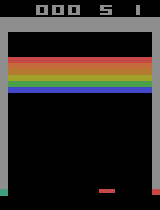

Episode 2
Episode 3
Episode 4
Episode 5
Episode 6
Episode 7
Episode 8
Episode 9
Episode 10
Episode 11


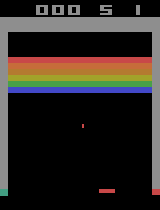

Episode 12
Episode 13
Episode 14
Episode 15
Episode 16
Episode 17
Episode 18
Episode 19
Episode 20
Episode 21


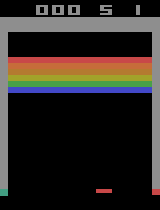

Episode 22
Episode 23
Episode 24
Episode 25
Episode 26
Episode 27
Episode 28
Episode 29
Episode 30
Episode 31


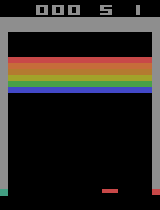

Episode 32
Episode 33
Episode 34
Episode 35
Episode 36
Episode 37
Episode 38
Episode 39
Episode 40
Episode 41


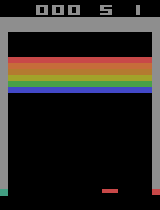

Episode 42
Episode 43
Episode 44
Episode 45
Episode 46
Episode 47
Episode 48
Episode 49
Episode 50
Episode 51


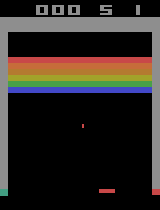

Episode 52
Episode 53
Episode 54
Episode 55
Episode 56
Episode 57
Episode 58
Episode 59
Episode 60
Episode 61


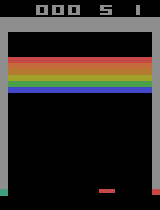

Episode 62
Episode 63
Episode 64
Episode 65
Episode 66
Episode 67
Episode 68
Episode 69
Episode 70
Episode 71


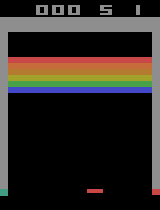

Episode 72
Episode 73
Episode 74
Episode 75
Episode 76
Episode 77
Episode 78
Episode 79
Episode 80
Episode 81


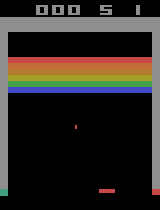

Episode 82
Episode 83
Episode 84
Episode 85
Episode 86
Episode 87
Episode 88
Episode 89
Episode 90
Episode 91


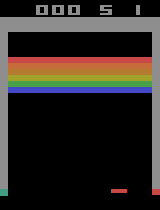

Episode 92
Episode 93
Episode 94
Episode 95
Episode 96
Episode 97
Episode 98
Episode 99
Episode 100
Episode 101


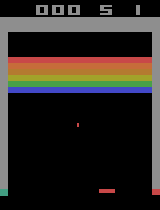

Episode 102
Episode 103
Episode 104
Episode 105
Episode 106
Episode 107
Episode 108
Episode 109
Episode 110
Episode 111


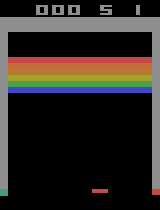

Episode 112
Episode 113
Episode 114
Episode 115
Episode 116
Episode 117
Episode 118
Episode 119
Episode 120
Episode 121


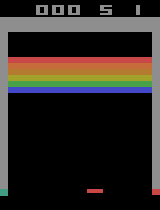

Episode 122
Episode 123
Episode 124
Episode 125
Episode 126
Episode 127
Episode 128
Episode 129
Episode 130
Episode 131


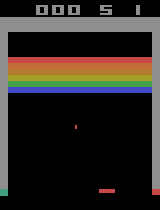

Episode 132
Episode 133
Episode 134
Episode 135
Episode 136
Episode 137
Episode 138
Episode 139
Episode 140
Episode 141


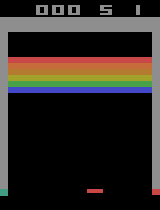

Episode 142
Episode 143
Episode 144
Episode 145
Episode 146
Episode 147
Episode 148
Episode 149
Episode 150
Episode 151


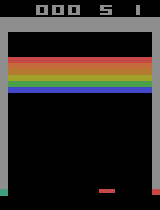

Episode 152
Episode 153
Episode 154
Episode 155
Episode 156
Episode 157
Episode 158
Episode 159
Episode 160
Episode 161


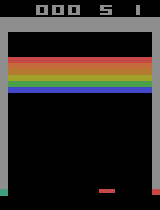

Episode 162
Episode 163
Episode 164
Episode 165
Episode 166
Episode 167
Episode 168
Episode 169
Episode 170
Episode 171


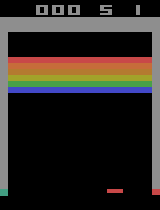

Episode 172
Episode 173
Episode 174
Episode 175
Episode 176
Episode 177
Episode 178
Episode 179
Episode 180
Episode 181


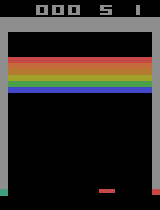

Episode 182
Episode 183
Episode 184
Episode 185
Episode 186
Episode 187
Episode 188
Episode 189
Episode 190
Episode 191


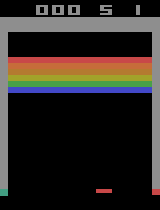

Episode 192
Episode 193
Episode 194
Episode 195
Episode 196
Episode 197
Episode 198
Episode 199
Episode 200
Episode 201


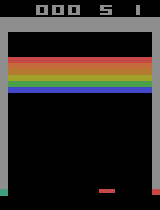

Episode 202
Episode 203
Episode 204
Episode 205
Episode 206
Episode 207
Episode 208
Episode 209
Episode 210
Episode 211


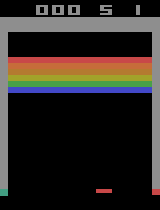

Episode 212
Episode 213
Episode 214
Episode 215
Episode 216
Episode 217
Episode 218
Episode 219
Episode 220
Episode 221


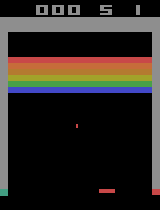

Episode 222
Episode 223
Episode 224
Episode 225
Episode 226
Episode 227
Episode 228
Episode 229
Episode 230
Episode 231


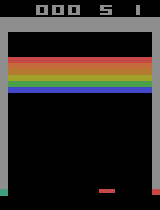

Episode 232
Episode 233
Episode 234
Episode 235
Episode 236
Episode 237
Episode 238
Episode 239
Episode 240
Episode 241


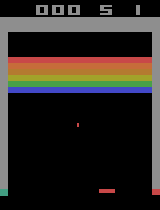

Episode 242
Episode 243
Episode 244
Episode 245
Episode 246
Episode 247
Episode 248
Episode 249
Episode 250
Episode 251


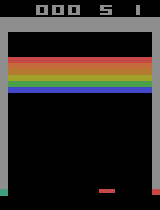

Episode 252
Episode 253
Episode 254
Episode 255
Episode 256
Episode 257
Episode 258
Episode 259
Episode 260
Episode 261


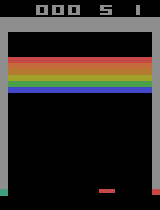

Episode 262
Episode 263
Episode 264
Episode 265
Episode 266
Episode 267
Episode 268
Episode 269
Episode 270
Episode 271


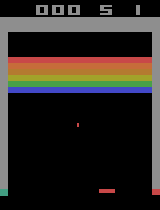

Episode 272
Episode 273
Episode 274
Episode 275
Episode 276
Episode 277
Episode 278
Episode 279
Episode 280
Episode 281


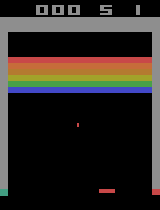

Episode 282
Episode 283
Episode 284
Episode 285
Episode 286
Episode 287
Episode 288
Episode 289
Episode 290
Episode 291


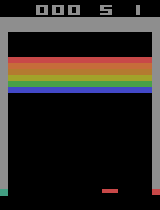

Episode 292
Episode 293
Episode 294
Episode 295
Episode 296
Episode 297
Episode 298
Episode 299
Episode 300
Episode 301


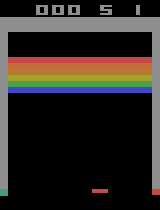

Episode 302
Episode 303
Episode 304
Episode 305
Episode 306
Episode 307
Episode 308
Episode 309
Episode 310
Episode 311


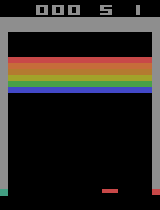

Episode 312
Episode 313
Episode 314
Episode 315
Episode 316
Episode 317
Episode 318
Episode 319
Episode 320
Episode 321


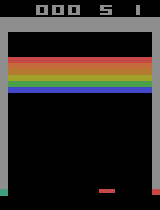

Episode 322
Episode 323
Episode 324
Episode 325
Episode 326
Episode 327
Episode 328
Episode 329
Episode 330
Episode 331


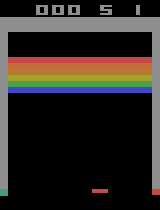

Episode 332
Episode 333
Episode 334
Episode 335
Episode 336
Episode 337
Episode 338
Episode 339
Episode 340
Episode 341


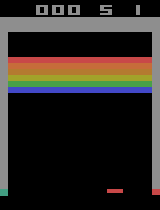

Episode 342
Episode 343
Episode 344
Episode 345
Episode 346
Episode 347
Episode 348
Episode 349
Episode 350
Episode 351


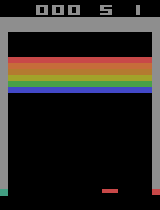

Episode 352
Episode 353
Episode 354
Episode 355
Episode 356
Episode 357
Episode 358
Episode 359
Episode 360
Episode 361


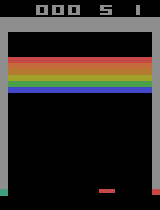

Episode 362
Episode 363
Episode 364
Episode 365
Episode 366
Episode 367
Episode 368
Episode 369
Episode 370
Episode 371


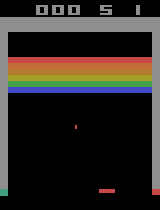

Episode 372
Episode 373
Episode 374
Episode 375
Episode 376
Episode 377
Episode 378
Episode 379
Episode 380
Episode 381


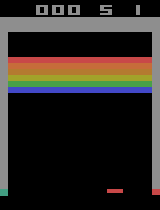

Episode 382
Episode 383
Episode 384
Episode 385
Episode 386
Episode 387
Episode 388
Episode 389
Episode 390
Episode 391


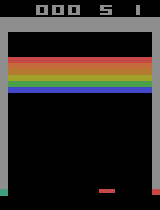

Episode 392
Episode 393
Episode 394
Episode 395
Episode 396
Episode 397
Episode 398
Episode 399
Episode 400
Episode 401


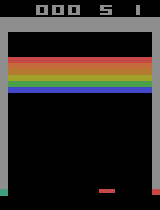

Episode 402
Episode 403
Episode 404
Episode 405
Episode 406
Episode 407
Episode 408
Episode 409
Episode 410
Episode 411


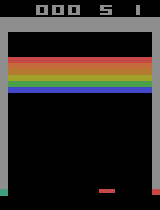

Episode 412
Episode 413
Episode 414
Episode 415
Episode 416
Episode 417
Episode 418
Episode 419
Episode 420
Episode 421


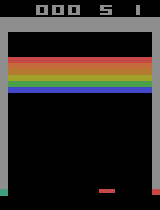

Episode 422
Episode 423
Episode 424
Episode 425
Episode 426
Episode 427
Episode 428
Episode 429
Episode 430
Episode 431


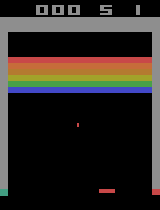

Episode 432
Episode 433
Episode 434
Episode 435
Episode 436
Episode 437
Episode 438
Episode 439
Episode 440
Episode 441


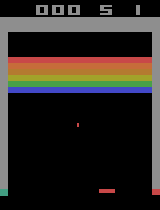

Episode 442
Episode 443
Episode 444
Episode 445
Episode 446
Episode 447
Episode 448
Episode 449
Episode 450
Episode 451


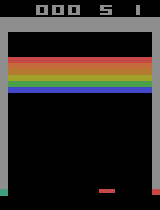

Episode 452
Episode 453
Episode 454
Episode 455
Episode 456
Episode 457
Episode 458
Episode 459
Episode 460
Episode 461


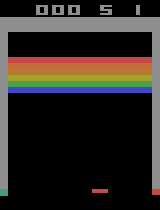

Episode 462
Episode 463
Episode 464
Episode 465
Episode 466
Episode 467
Episode 468
Episode 469
Episode 470
Episode 471


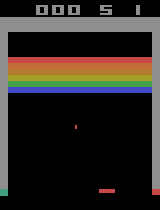

Episode 472
Episode 473
Episode 474
Episode 475
Episode 476
Episode 477
Episode 478
Episode 479
Episode 480
Episode 481


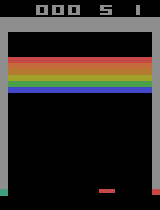

Episode 482
Episode 483
Episode 484
Episode 485
Episode 486
Episode 487
Episode 488
Episode 489
Episode 490
Episode 491


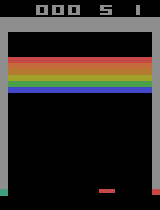

Episode 492
Episode 493
Episode 494
Episode 495
Episode 496
Episode 497
Episode 498
Episode 499
Episode 500
Episode 501


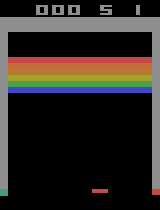

Episode 502
Episode 503
Episode 504
Episode 505
Episode 506
Episode 507
Episode 508
Episode 509
Episode 510
Episode 511


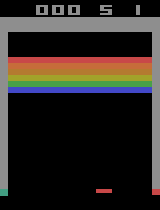

Episode 512
Episode 513
Episode 514
Episode 515
Episode 516
Episode 517
Episode 518
Episode 519
Episode 520
Episode 521


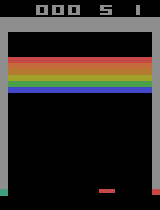

Episode 522
Episode 523
Episode 524
Episode 525
Episode 526
Episode 527
Episode 528
Episode 529
Episode 530
Episode 531


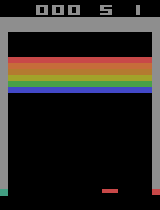

Episode 532
Episode 533
Episode 534
Episode 535
Episode 536
Episode 537
Episode 538
Episode 539
Episode 540
Episode 541


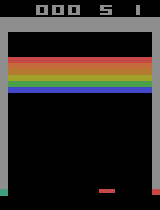

Episode 542
Episode 543
Episode 544
Episode 545
Episode 546
Episode 547
Episode 548
Episode 549
Episode 550
Episode 551


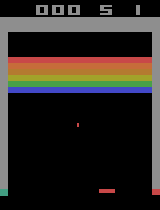

Episode 552
Episode 553
Episode 554
Episode 555
Episode 556
Episode 557
Episode 558
Episode 559
Episode 560
Episode 561


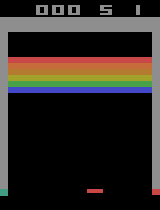

Episode 562
Episode 563
Episode 564
Episode 565
Episode 566
Episode 567
Episode 568
Episode 569
Episode 570
Episode 571


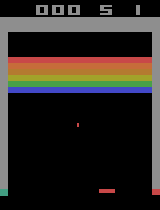

Episode 572
Episode 573
Episode 574
Episode 575
Episode 576
Episode 577
Episode 578
Episode 579
Episode 580
Episode 581


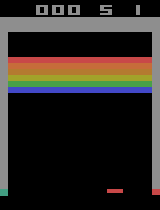

Episode 582
Episode 583
Episode 584
Episode 585
Episode 586
Episode 587
Episode 588
Episode 589
Episode 590
Episode 591


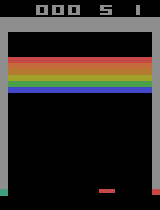

Episode 592
Episode 593
Episode 594
Episode 595
Episode 596
Episode 597
Episode 598
Episode 599
Episode 600
Episode 601


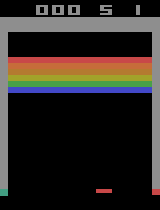

Episode 602
Episode 603
Episode 604
Episode 605
Episode 606
Episode 607
Episode 608
Episode 609
Episode 610
Episode 611


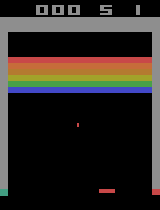

Episode 612
Episode 613
Episode 614
Episode 615
Episode 616
Episode 617
Episode 618
Episode 619
Episode 620
Episode 621


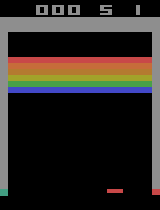

Episode 622
Episode 623
Episode 624
Episode 625
Episode 626
Episode 627
Episode 628
Episode 629
Episode 630
Episode 631


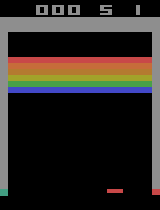

Episode 632
Episode 633
Episode 634
Episode 635
Episode 636
Episode 637
Episode 638
Episode 639
Episode 640
Episode 641


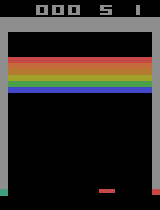

Episode 642
Episode 643
Episode 644
Episode 645
Episode 646
Episode 647
Episode 648
Episode 649
Episode 650
Episode 651


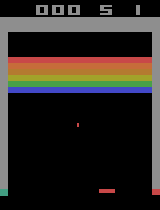

Episode 652
Episode 653
Episode 654
Episode 655
Episode 656
Episode 657
Episode 658
Episode 659
Episode 660
Episode 661


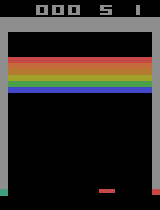

Episode 662
Episode 663
Episode 664
Episode 665
Episode 666
Episode 667
Episode 668
Episode 669
Episode 670
Episode 671


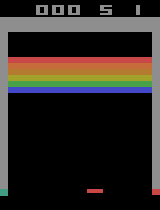

Episode 672
Episode 673
Episode 674
Episode 675
Episode 676
Episode 677
Episode 678
Episode 679
Episode 680
Episode 681


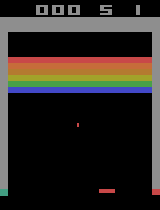

Episode 682
Episode 683
Episode 684
Episode 685
Episode 686
Episode 687
Episode 688
Episode 689
Episode 690
Episode 691


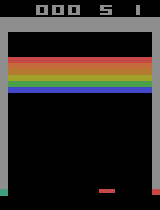

Episode 692
Episode 693
Episode 694
Episode 695
Episode 696
Episode 697
Episode 698
Episode 699
Episode 700
Episode 701


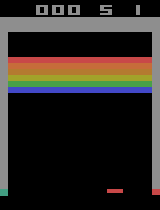

Episode 702
Episode 703
Episode 704
Episode 705
Episode 706
Episode 707
Episode 708
Episode 709
Episode 710
Episode 711


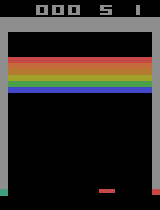

Episode 712
Episode 713
Episode 714
Episode 715
Episode 716
Episode 717
Episode 718
Episode 719
Episode 720
Episode 721


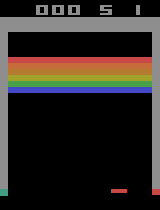

Episode 722
Episode 723
Episode 724
Episode 725
Episode 726
Episode 727
Episode 728
Episode 729
Episode 730
Episode 731


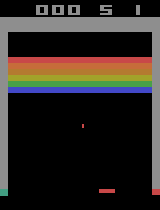

Episode 732
Episode 733
Episode 734
Episode 735
Episode 736
Episode 737
Episode 738
Episode 739
Episode 740
Episode 741


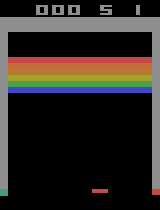

Episode 742
Episode 743
Episode 744
Episode 745
Episode 746
Episode 747
Episode 748
Episode 749
Episode 750
Episode 751


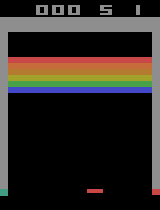

Episode 752
Episode 753
Episode 754
Episode 755
Episode 756
Episode 757
Episode 758
Episode 759
Episode 760
Episode 761


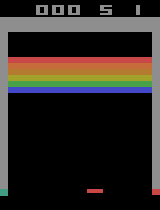

Episode 762
Episode 763
Episode 764
Episode 765
Episode 766
Episode 767
Episode 768
Episode 769
Episode 770
Episode 771


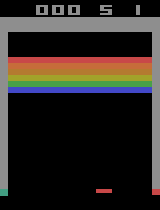

Episode 772
Episode 773
Episode 774
Episode 775
Episode 776
Episode 777
Episode 778
Episode 779
Episode 780
Episode 781


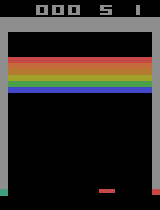

Episode 782
Episode 783
Episode 784
Episode 785
Episode 786
Episode 787
Episode 788
Episode 789
Episode 790
Episode 791


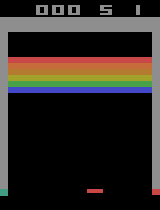

Episode 792
Episode 793
Episode 794
Episode 795
Episode 796
Episode 797
Episode 798
Episode 799
Episode 800
Episode 801


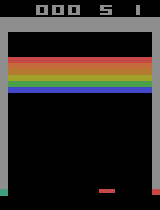

Episode 802
Episode 803
Episode 804
Episode 805
Episode 806
Episode 807
Episode 808
Episode 809
Episode 810
Episode 811


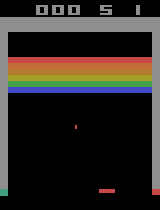

Episode 812
Episode 813
Episode 814
Episode 815
Episode 816
Episode 817
Episode 818
Episode 819
Episode 820
Episode 821


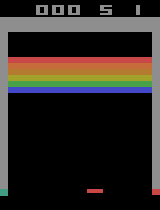

Episode 822
Episode 823
Episode 824
Episode 825
Episode 826
Episode 827
Episode 828
Episode 829
Episode 830
Episode 831


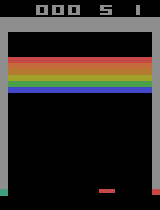

Episode 832
Episode 833
Episode 834
Episode 835
Episode 836
Episode 837
Episode 838
Episode 839
Episode 840
Episode 841


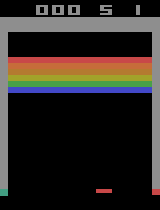

Episode 842
Episode 843
Episode 844
Episode 845
Episode 846
Episode 847
Episode 848
Episode 849
Episode 850
Episode 851


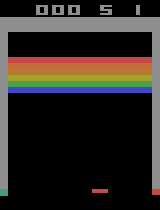

Episode 852
Episode 853
Episode 854
Episode 855
Episode 856
Episode 857
Episode 858
Episode 859
Episode 860
Episode 861


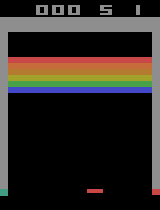

Episode 862
Episode 863
Episode 864
Episode 865
Episode 866
Episode 867
Episode 868
Episode 869
Episode 870
Episode 871


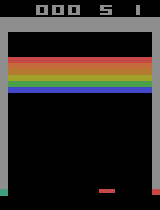

Episode 872
Episode 873
Episode 874
Episode 875
Episode 876
Episode 877
Episode 878
Episode 879
Episode 880
Episode 881


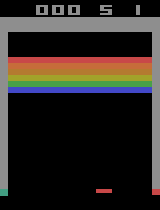

Episode 882
Episode 883
Episode 884
Episode 885
Episode 886
Episode 887
Episode 888
Episode 889
Episode 890
Episode 891


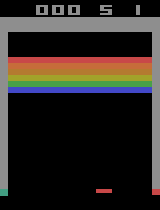

Episode 892
Episode 893
Episode 894
Episode 895
Episode 896
Episode 897
Episode 898
Episode 899
Episode 900
Episode 901


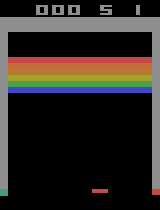

Episode 902
Episode 903
Episode 904
Episode 905
Episode 906
Episode 907
Episode 908
Episode 909
Episode 910
Episode 911


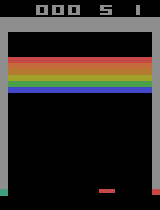

Episode 912
Episode 913
Episode 914
Episode 915
Episode 916
Episode 917
Episode 918
Episode 919
Episode 920
Episode 921


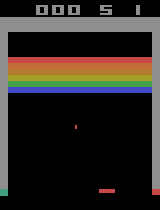

Episode 922
Episode 923
Episode 924
Episode 925
Episode 926
Episode 927
Episode 928
Episode 929
Episode 930
Episode 931


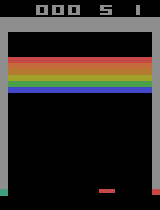

Episode 932
Episode 933
Episode 934
Episode 935
Episode 936
Episode 937
Episode 938
Episode 939
Episode 940
Episode 941


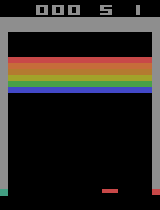

Episode 942
Episode 943
Episode 944
Episode 945
Episode 946
Episode 947
Episode 948
Episode 949
Episode 950
Episode 951


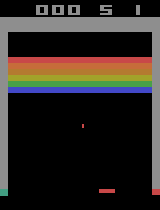

Episode 952
Episode 953
Episode 954
Episode 955
Episode 956
Episode 957
Episode 958
Episode 959
Episode 960
Episode 961


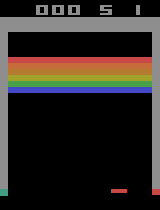

Episode 962
Episode 963
Episode 964
Episode 965
Episode 966
Episode 967
Episode 968
Episode 969
Episode 970
Episode 971


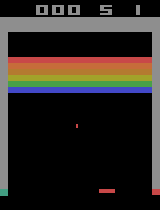

Episode 972
Episode 973
Episode 974
Episode 975
Episode 976
Episode 977
Episode 978
Episode 979
Episode 980
Episode 981


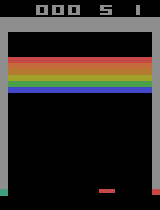

Episode 982
Episode 983
Episode 984
Episode 985
Episode 986
Episode 987
Episode 988
Episode 989
Episode 990
Episode 991


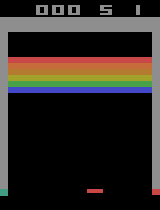

Episode 992
Episode 993
Episode 994
Episode 995
Episode 996
Episode 997
Episode 998
Episode 999
Episode 1000
Complete


In [ ]:
import numpy as np
from itertools import count
import time
from IPython.display import Image, display as ipy_display  # Rename display to ipy_display
import imageio


def create_gif(frames, filename='episode.gif'):
    # Set duration to 33 milliseconds per frame (about 30 frames per second)
    imageio.mimsave(filename, frames, duration=33)  # Save GIF
    return filename

for i_episode in range(num_episodes):
    print(f"Episode {i_episode+1}")
    env.reset()
    frames = []
    state = get_screen()  # Assume get_screen is defined to capture processed screen
    for t in count():
        action = select_action(state)
        _, reward, done, _ = env.step(action.item())
        reward = torch.tensor([reward], device=device)
        frames.append(env.render(mode='rgb_array'))  # Save the current frame

        if not done:
            next_state = get_screen()
        else:
            next_state = None

        memory.push(state, action, next_state, reward)
        state = next_state

        optimize_model()

        if done:
            break

    if i_episode % TARGET_UPDATE == 0:
        target_net.load_state_dict(policy_net.state_dict())

    if i_episode % 10 == 0:  # Create and display a GIF every 5 episodes
        gif_path = create_gif(frames)
        ipy_display(Image(filename=gif_path))  # Use the renamed display function

print('Complete')
env.close()

In [ ]:
for i_episode in range(num_episodes):
    print(i_episode)
    env.reset()
    frames = []
    state = get_screen()  # Initial state
    for t in count():
        action = select_action(state)
        _, reward, done, _ = env.step(action.item())
        state = get_screen()  # Update the state

        frames.append(env.render(mode='rgb_array'))  # Save the current frame

        if done:
            break

    if i_episode % 10 == 0:  # Create and display a GIF every 5 episodes
        gif_path = create_gif(frames)
        ipy_display(Image(filename=gif_path))  # Use the renamed display function

print('Complete')
env.close()